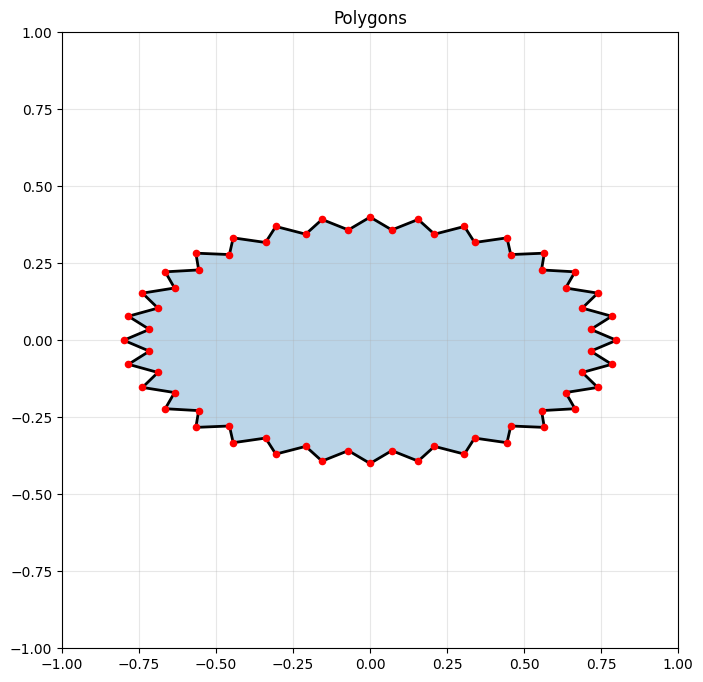

In [1]:
from ainr.ground_truth import generate_polygons
from ainr.vis import plot_polygons

polygons = generate_polygons('1x32', convex=False, stretch=(1, 0.5), star_ratio=0.9)
plot_polygons(polygons)

In [2]:
from dataclasses import dataclass
from typing import List
import numpy as np
from ainr.model import ReluMLP
from ainr.vis import plot_cell_sdf
from typing import Tuple
import torch
import copy

@dataclass
class Surface2D:
    vertices: np.ndarray
    closed: bool

def split_surface_by_hyperplane(surfaces: List[Surface2D], n: np.ndarray, d: float, eps=1e-8):
    result_surfaces = []
    
    for orig_surface in surfaces:
        SD = orig_surface.vertices @ n + d
    
        SD_min = SD.min()
        SD_max = SD.max()

        if SD_min > -eps:
            # Case 1.1: No split - all vertices are positive
            result_surfaces.append(orig_surface)
            continue
        elif SD_max < eps:
            # Case 1.2: No split - all vertices are negative
            result_surfaces.append(orig_surface)
            continue
        
        V = orig_surface.vertices
        ON = np.abs(SD) <= eps
        S = np.sign(SD).astype(np.int8)
        S[ON] = 0

        n_verts = len(V)
        
        current_V = []
        first_surface_idx = len(result_surfaces)  # Track where we start adding surfaces for this split
        
        for i in range(0, n_verts):
            if ON[i]:
                current_V.append(V[i])
                # Determine previous sign
                if orig_surface.closed:
                    prev_sign = S[i-1]
                elif i > 0:
                    prev_sign = S[i-1]
                else:
                    # i=0 and open surface - first vertex is on plane, no previous sign
                    current_V = [V[i]]
                    continue
                
                new_surface = Surface2D(
                    np.array(current_V),
                    False,
                )
                result_surfaces.append(new_surface)
                current_V = [V[i]]
                continue
            elif (orig_surface.closed or i > 0) and S[i] * S[i-1] == -1:
                denom = SD[i] - SD[i-1]
                t = -SD[i-1] / denom
                P = V[i-1] + t * (V[i] - V[i-1])
                current_V.append(P)

                new_surface = Surface2D(
                    np.array(current_V),
                    False,
                )
                result_surfaces.append(new_surface)
                current_V = [P, V[i]]
                continue

            current_V.append(V[i])
        
        # Handle remaining vertices
        if orig_surface.closed and len(result_surfaces) > first_surface_idx:
            # Connect the end back to the first surface of this split
            result_surfaces[first_surface_idx].vertices = np.concatenate([
                np.array(current_V), 
                result_surfaces[first_surface_idx].vertices
            ])
        elif len(current_V) > 1:
            new_surface = Surface2D(
                np.array(current_V),
                False,
            )
            result_surfaces.append(new_surface)
    
    return result_surfaces

def compute_surface_split(surface: Surface2D):
    V = surface.vertices
    middle_index = len(V)//2
    left_index = middle_index - 1
    right_index = middle_index + 1

    vertex = V[middle_index]
    vertex_prev = V[left_index]
    vertex_next = V[right_index]

    # Compute edge vectors
    edge_before = vertex - vertex_prev  # Points TO current vertex
    edge_after = vertex_next - vertex   # Points FROM current vertex

    # Normalize edge directions
    edge_before_norm = edge_before / (np.linalg.norm(edge_before) + 1e-8)
    edge_after_norm = edge_after / (np.linalg.norm(edge_after) + 1e-8)

    # FLIP edge_before since it points backwards (into the vertex)
    # We want both to point "forward" along the polygon boundary
    edge_before_norm = -edge_before_norm

    # Average the edge directions to get the tangent bisector
    tangent_bisector = (edge_before_norm + edge_after_norm) / 2
    tangent_bisector = tangent_bisector / (np.linalg.norm(tangent_bisector) + 1e-8)

    # Rotate tangent bisector 90° CCW to get the boundary normal (perpendicular to bisector)
    boundary_normal = np.stack([-tangent_bisector[1], tangent_bisector[0]])

    # Compute offsets
    offset = -np.sum(boundary_normal * vertex)
    
    return boundary_normal, offset

def get_split_for_largest_surface(surfaces: List[Surface2D]):
    surface_count = np.array([
        len(surface.vertices) if surface.closed else len(surface.vertices)-2
        for surface in surfaces
    ])

    if np.all(surface_count==0):
        return None, None

    surface_idx = np.argmax(surface_count)
    surface = surfaces[surface_idx]
    return compute_surface_split(surface)

def get_largest_surfaces(surfaces: List[Surface2D]):
    surface_count = np.array([
        len(surface.vertices) if surface.closed else len(surface.vertices)-2
        for surface in surfaces
    ])
    
    if np.all(surface_count==0):
        return None, None
    
    surface_indices = np.argsort(surface_count)[::-1]
    return surface_indices

def add_hyperplane_constraint(weight: np.ndarray,
                              bias: np.ndarray,
                              A: np.ndarray,
                              y: np.ndarray,
                              normal: np.ndarray,
                              offset: np.ndarray,
                              hidden_dim: int,
                              surface_idx: int):
    """
    Add a constraint that the layer should produce a specific hyperplane split.
    
    We want: w_layer @ (weight @ x + bias) + b_layer = normal @ x + offset
    This gives us 3 equations (2 for normal components, 1 for offset).
    """
    row_x = np.zeros(hidden_dim + 1)
    row_x[:hidden_dim] = weight[:, 0]

    row_y = np.zeros(hidden_dim + 1)
    row_y[:hidden_dim] = weight[:, 1]

    row_c = np.zeros(hidden_dim + 1)
    row_c[:hidden_dim] = bias
    row_c[hidden_dim] = 1.0

    A_new = np.vstack([row_x, row_y, row_c])
    y_new = np.array([normal[0], normal[1], offset])

    A_candidate = np.vstack([A, A_new]) if A.shape[0] > 0 else A_new
    y_candidate = np.hstack([y, y_new]) if y.shape[0] > 0 else y_new

    # Check consistency using rank test
    A_augmented = np.column_stack([A_candidate, y_candidate])
    rank_A = np.linalg.matrix_rank(A_candidate, tol=1e-10)
    rank_aug = np.linalg.matrix_rank(A_augmented, tol=1e-10)

    # if rank_A != rank_aug:
    #     # print(f"Surface {surface_idx}: Inconsistent system - skipping")
    #     return False, A, y, None

    # Solve the system
    solution, residuals, rank, s = np.linalg.lstsq(A_candidate, y_candidate, rcond=None)
    
    # Verify solution accuracy
    verification = A_candidate @ solution
    error = np.abs(verification - y_candidate)
    max_error = np.max(error)

    if max_error > 1e-6:
        print(f"Surface {surface_idx}: Solution error too large - skipping")
        return False, A, y, None
    
    return True, A_candidate, y_candidate, solution


def solve_layer_weights(surfaces: List[Surface2D], 
                        params: List[Tuple[np.ndarray, np.ndarray]], 
                        hidden_dim: int,
                        layer_idx: int,
                        neuron_pair_idx: int,
                        vis=False):
    """
    Solve for layer weights by accumulating hyperplane constraints from all surfaces.
    
    Returns:
        Tuple of (w_hidden_data, w_hidden_offset) or (None, None) if no solution found
    """
    solution = None
    A = np.empty((0, hidden_dim + 1))
    y = np.empty(0)
    
    sort = True
    if sort:
        indices = get_largest_surfaces(surfaces)
        surfaces = [surfaces[i] for i in indices]
        params = [params[i] for i in indices]
    for surface_idx, (surface, (weight, bias)) in enumerate(zip(surfaces, params)):
        if len(surface.vertices) <= 2:
            continue
        normal, offset = compute_surface_split(surface)
        success, A, y, new_solution = add_hyperplane_constraint(
            weight, bias, A, y, normal, offset, hidden_dim, surface_idx
        )
        if success:
            if vis:
                mlp.layers[layer_idx].weight.data[2*neuron_pair_idx, :] = torch.tensor(new_solution[:hidden_dim], dtype=torch.float32)
                mlp.layers[layer_idx].bias.data[2*neuron_pair_idx] = torch.tensor(new_solution[hidden_dim], dtype=torch.float32)
                mlp.layers[layer_idx].weight.data[2*neuron_pair_idx+1, :] = torch.tensor(-new_solution[:hidden_dim], dtype=torch.float32)
                mlp.layers[layer_idx].bias.data[2*neuron_pair_idx+1] = torch.tensor(-new_solution[hidden_dim], dtype=torch.float32)
                plot_cell_sdf(mlp, surfaces=surfaces, title=f"Surface {surface_idx}: Successfully added", highlight_idx=surface_idx)
            solution = new_solution
        elif vis:
            plot_cell_sdf(mlp, surfaces=surfaces, title=f"Surface {surface_idx}: Failed to add", highlight_idx=surface_idx)
    
    if solution is None:
        return None, None
    
    w_hidden_data = solution[:hidden_dim]
    w_hidden_offset = solution[hidden_dim]
    return w_hidden_data, w_hidden_offset


def apply_layer_splits(surfaces: List[Surface2D],
                      params: List[Tuple[np.ndarray, np.ndarray]],
                      w_hidden_data: np.ndarray,
                      w_hidden_offset: float):
    """
    Apply a layer's learned weights to split all surfaces.
    
    For each surface, compute the effective hyperplane in input space and split.
    """
    new_surfaces = []
    new_params = []
    
    for surface, (weight, bias) in zip(surfaces, params):
        # Compute effective hyperplane: w_layer @ (weight @ x + bias) + offset
        # = (w_layer @ weight) @ x + (w_layer @ bias + offset)
        effective_normal_unnorm = w_hidden_data @ weight
        effective_offset_unnorm = w_hidden_data @ bias + w_hidden_offset

        norm = np.linalg.norm(effective_normal_unnorm)
        if norm < 1e-8:
            # Degenerate hyperplane - keep surface unchanged
            new_surfaces.append(surface)
            new_params.append((weight, bias))
            continue

        # Normalize
        effective_normal = effective_normal_unnorm / norm
        effective_offset = effective_offset_unnorm / norm
        
        # Split the surface
        split_surfaces = split_surface_by_hyperplane([surface], effective_normal, effective_offset)
        new_surfaces.extend(split_surfaces)
        new_params.extend([(weight, bias) for _ in range(len(split_surfaces))])

    return new_surfaces, new_params


def collapse_layers(surfaces: List[Surface2D],
                   params: List[Tuple[np.ndarray, np.ndarray]],
                   next_layer_weight: torch.Tensor,
                   next_layer_bias: torch.Tensor):
    """
    Collapse/compose two consecutive layers together.
    
    For each surface region, determine which neurons are active in the next layer,
    then compose: layer_next(layer_prev(x)) = W_next @ (W_prev @ x + b_prev) + b_next
                                             = (W_next @ W_prev) @ x + (W_next @ b_prev + b_next)
    """
    new_params = []
    
    for surface, (weight, bias) in zip(surfaces, params):
        # Compute previous layer output at a representative point
        vertex = np.mean(surface.vertices, axis=0)
        prev_out = weight @ vertex + bias
        
        # Get next layer weights
        next_weight = np.array(next_layer_weight)
        next_bias = np.array(next_layer_bias)
        
        # Check which next layer neurons are active
        next_preact = next_weight @ prev_out + next_bias
        mask = next_preact < 0  # Inactive neurons
        
        # Zero out inactive neurons
        next_weight_collapsed = next_weight.copy()
        next_bias_collapsed = next_bias.copy()
        next_weight_collapsed[mask, :] = 0
        next_bias_collapsed[mask] = 0
        
        # Compose the layers
        composed_weight = next_weight_collapsed @ weight
        composed_bias = next_weight_collapsed @ bias + next_bias_collapsed
        
        new_params.append((composed_weight, composed_bias))
    
    return new_params


def solve_output_layer_analytically(mlp: ReluMLP,
                                   surfaces: List[Surface2D],
                                   params: List[Tuple[np.ndarray, np.ndarray]]):
    A_rows = []
    y_targets = []
    
    # For each surface segment, compute target geometry from first and last vertex
    for surface, (weight, bias) in zip(surfaces, params):
        if len(surface.vertices) < 2:
            continue
        
        # Get first and last vertex
        V0, V1 = surface.vertices[0], surface.vertices[-1]
        edge = V1 - V0
        
        # Normal vector (-dy, dx)
        normal = np.array([-edge[1], edge[0]])
        norm_len = np.linalg.norm(normal)
        
        if norm_len < 1e-9:
            continue
        
        # Normalize and negate to flip SDF: negative inside, positive outside
        unit_normal = normal / norm_len
        target_n = -unit_normal
        target_c = np.dot(V0, unit_normal)
        
        # Build constraint matrix
        # We want: W_out @ (weight @ x + bias) + b_out = target_n @ x + target_c
        # Expanding: (W_out @ weight) @ x + (W_out @ bias + b_out) = target_n @ x + target_c
        
        # Row 1: Match x-component of normal
        row_x = np.zeros(mlp.hidden_dim + 1)
        row_x[:mlp.hidden_dim] = weight[:, 0]
        A_rows.append(row_x)
        y_targets.append(target_n[0])
        
        # Row 2: Match y-component of normal
        row_y = np.zeros(mlp.hidden_dim + 1)
        row_y[:mlp.hidden_dim] = weight[:, 1]
        A_rows.append(row_y)
        y_targets.append(target_n[1])
        
        # Row 3: Match offset
        row_c = np.zeros(mlp.hidden_dim + 1)
        row_c[:mlp.hidden_dim] = bias
        row_c[mlp.hidden_dim] = 1.0
        A_rows.append(row_c)
        y_targets.append(target_c)
    
    # Solve the least squares system
    A = np.array(A_rows)
    y = np.array(y_targets)
    
    solution, residuals, rank, s = np.linalg.lstsq(A, y, rcond=None)
    
    # Verify solution quality
    verification = A @ solution
    error = np.abs(verification - y)
    max_error = np.max(error)
    rms_error = np.sqrt(np.mean(error ** 2))
    
    print(f"  Rank={rank}/{A.shape[1]}, RMS error={rms_error:.6f}, max error={max_error:.6f}")
    
    # Extract weights and bias
    w_out = solution[:mlp.hidden_dim]
    b_out = solution[mlp.hidden_dim]
    
    # Set the output layer parameters
    output_layer_idx = mlp.num_layers
    mlp.layers[output_layer_idx].weight.data = torch.tensor(w_out.reshape(1, -1), dtype=torch.float32)
    mlp.layers[output_layer_idx].bias.data = torch.tensor([b_out], dtype=torch.float32)
    
    return True


def build_layer(mlp: ReluMLP, 
               layer_idx: int,
               surfaces: List[Surface2D], 
               params: List[Tuple[np.ndarray, np.ndarray]],
               vis=False):
    """
    Build a single layer by solving for neuron weights and applying splits.
    
    Args:
        mlp: The MLP being constructed
        layer_idx: Which layer to build (0, 1, 2, ...)
        surfaces: Current list of surface segments
        params: Current collapsed weight/bias parameters for each surface
        vis: Whether to visualize the process
        
    Returns:
        Updated surfaces and params after this layer's splits
    """
    
    for neuron_pair_idx in range(mlp.hidden_dim // 2):
        # Layer 0: Direct splits on input space (no constraint solving needed)
        if layer_idx == 0:
            # Use greedy largest-first strategy
            normal, offset = get_split_for_largest_surface(surfaces)
            if normal is None:
                if vis:
                    plot_cell_sdf(mlp, surfaces=surfaces, title=f"Layer {layer_idx + 1}, Neuron pair {neuron_pair_idx}: No more surfaces to split")
                break
            w_hidden_data, w_hidden_offset = normal, offset
        else:
            # Layers 1+: Solve for weights that produce desired splits
            w_hidden_data, w_hidden_offset = solve_layer_weights(
                surfaces, params, mlp.hidden_dim, layer_idx=layer_idx, neuron_pair_idx=neuron_pair_idx, vis=vis
            )
            if w_hidden_data is None:
                if vis:
                    plot_cell_sdf(mlp, surfaces=surfaces, title=f"Layer {layer_idx + 1}, Neuron pair {neuron_pair_idx}: No solution found - skipping")
                continue
        
        # Apply the splits to all surfaces
        surfaces, params = apply_layer_splits(
            surfaces, params, w_hidden_data, w_hidden_offset
        )
        
        # Set neuron weights (positive and negative pairs)
        mlp.layers[layer_idx].weight.data[2*neuron_pair_idx, :] = torch.tensor(w_hidden_data, dtype=torch.float32)
        mlp.layers[layer_idx].bias.data[2*neuron_pair_idx] = torch.tensor(w_hidden_offset, dtype=torch.float32)
        mlp.layers[layer_idx].weight.data[2*neuron_pair_idx+1, :] = torch.tensor(-w_hidden_data, dtype=torch.float32)
        mlp.layers[layer_idx].bias.data[2*neuron_pair_idx+1] = torch.tensor(-w_hidden_offset, dtype=torch.float32)
        if vis:
            plot_cell_sdf(mlp, surfaces=surfaces, title=f"Layer {layer_idx + 1}, Neuron pair {neuron_pair_idx}: Applied splits")
    
    return surfaces, params


Surface 1: Solution error too large - skipping
Surface 3: Solution error too large - skipping
Surface 4: Solution error too large - skipping
Surface 5: Solution error too large - skipping
Surface 6: Solution error too large - skipping
Surface 7: Solution error too large - skipping
Surface 1: Solution error too large - skipping
Surface 3: Solution error too large - skipping
Surface 4: Solution error too large - skipping
Surface 5: Solution error too large - skipping
Surface 6: Solution error too large - skipping
Surface 7: Solution error too large - skipping
Surface 8: Solution error too large - skipping
Surface 9: Solution error too large - skipping
Surface 1: Solution error too large - skipping
Surface 2: Solution error too large - skipping
Surface 4: Solution error too large - skipping
Surface 5: Solution error too large - skipping
Surface 6: Solution error too large - skipping
Surface 7: Solution error too large - skipping
Surface 8: Solution error too large - skipping
Surface 9: So

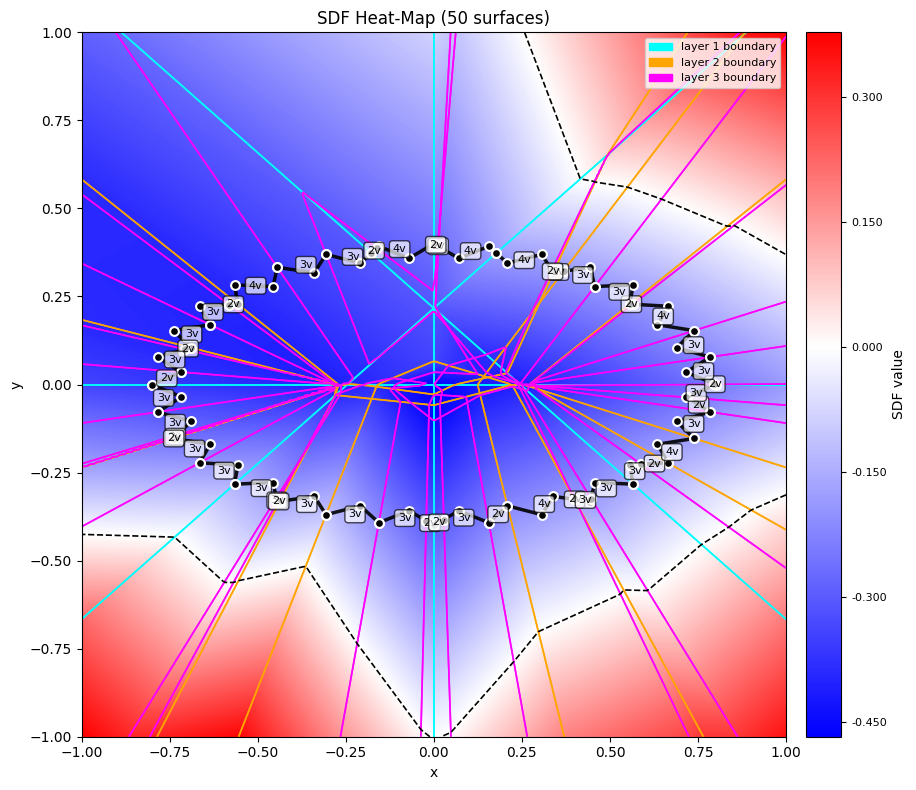

In [8]:
surfaces = [Surface2D(polygon, True) for polygon in polygons]
mlp = ReluMLP(2, 8, 3, skip_connections=False)

# Initialize params with identity transformation (no previous layer)
# For each surface: weight @ x + bias = I @ x + 0 = x
new_surfaces = copy.deepcopy(surfaces)
params: List[Tuple[np.ndarray, np.ndarray]] = [
    (np.eye(2), np.zeros(2)) for _ in surfaces
]

for layer in mlp.layers:
    layer.weight.data = torch.zeros_like(layer.weight.data)
    layer.bias.data = torch.zeros_like(layer.bias.data)

# Build all layers iteratively
for layer_idx in range(mlp.num_layers):
    # Build layer
    new_surfaces, params = build_layer(mlp, layer_idx, new_surfaces, params, vis=False)
    
    # Collapse previous layers with this layer
    params = collapse_layers(
        new_surfaces, params, 
        mlp.layers[layer_idx].weight.data, 
        mlp.layers[layer_idx].bias.data
    )

# Solve output layer analytically using boundary constraints
solve_output_layer_analytically(mlp, new_surfaces, params)

plot_cell_sdf(mlp, surfaces=new_surfaces)

In [4]:
import torch.optim as optim
from typing import Tuple
import time

def polygon_sdf(point: np.ndarray, polygon: np.ndarray) -> float:
    """
    Compute signed distance from a point to a polygon.
    Negative inside, positive outside.
    
    Args:
        point: 2D point (x, y)
        polygon: Polygon vertices (n_vertices, 2)
    
    Returns:
        Signed distance value
    """
    n = len(polygon)
    min_dist_sq = float('inf')
    inside = False
    
    for i in range(n):
        v1 = polygon[i]
        v2 = polygon[(i + 1) % n]
        
        # Edge vector and point-to-v1 vector
        edge = v2 - v1
        to_point = point - v1
        
        # Project point onto edge
        edge_len_sq = np.dot(edge, edge)
        if edge_len_sq < 1e-10:
            # Degenerate edge
            dist_sq = np.dot(to_point, to_point)
        else:
            t = np.clip(np.dot(to_point, edge) / edge_len_sq, 0, 1)
            closest = v1 + t * edge
            diff = point - closest
            dist_sq = np.dot(diff, diff)
        
        min_dist_sq = min(min_dist_sq, dist_sq)
        
        # Inside/outside test using winding number
        if v1[1] <= point[1]:
            if v2[1] > point[1]:
                if np.cross(edge, to_point) > 0:
                    inside = not inside
        else:
            if v2[1] <= point[1]:
                if np.cross(edge, to_point) < 0:
                    inside = not inside
    
    dist = np.sqrt(min_dist_sq)
    return -dist if inside else dist


def compute_ground_truth_sdf(points: torch.Tensor, polygons: List[np.ndarray]) -> torch.Tensor:
    """
    Compute ground truth SDF for a batch of points.
    
    Args:
        points: (N, 2) tensor of query points
        polygons: List of polygon vertex arrays
    
    Returns:
        (N,) tensor of SDF values (minimum distance to any polygon)
    """
    points_np = points.cpu().numpy()
    n_points = len(points_np)
    sdf_values = np.zeros(n_points)
    
    for i, point in enumerate(points_np):
        # Compute SDF to each polygon and take minimum absolute value with correct sign
        min_sdf = float('inf')
        for polygon in polygons:
            sdf = polygon_sdf(point, polygon)
            if abs(sdf) < abs(min_sdf):
                min_sdf = sdf
        sdf_values[i] = min_sdf
    
    return torch.tensor(sdf_values, dtype=torch.float32, device=points.device)


def sample_training_points(polygons: List[np.ndarray], 
                           n_surface: int = 1000,
                           n_near: int = 2000, 
                           n_far: int = 500,
                           near_distance: float = 0.1) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Sample training points with emphasis on polygon surfaces and nearby regions.
    
    Args:
        polygons: List of polygon vertex arrays
        n_surface: Number of points to sample on polygon edges
        n_near: Number of points to sample near polygons
        n_far: Number of random points in the domain
        near_distance: Maximum distance for "near" points
    
    Returns:
        Tuple of (points, sdf_values)
    """
    all_points = []
    
    # 1. Sample points on polygon edges
    for polygon in polygons:
        n_edges = len(polygon)
        for i in range(n_edges):
            v1 = polygon[i]
            v2 = polygon[(i + 1) % n_edges]
            # Sample along edge
            n_samples = max(n_surface // (len(polygons) * n_edges), 5)
            t = np.random.rand(n_samples, 1)
            edge_points = v1 + t * (v2 - v1)
            all_points.append(edge_points)
    
    # 2. Sample points near polygon edges
    for polygon in polygons:
        n_edges = len(polygon)
        for i in range(n_edges):
            v1 = polygon[i]
            v2 = polygon[(i + 1) % n_edges]
            edge = v2 - v1
            edge_normal = np.array([-edge[1], edge[0]])
            edge_normal = edge_normal / (np.linalg.norm(edge_normal) + 1e-8)
            
            n_samples = max(n_near // (len(polygons) * n_edges), 10)
            t = np.random.rand(n_samples, 1)
            offsets = (np.random.rand(n_samples, 1) - 0.5) * 2 * near_distance
            
            edge_points = v1 + t * (v2 - v1)
            near_points = edge_points + offsets * edge_normal
            all_points.append(near_points)
    
    # 3. Sample random points in domain [-1, 1]^2
    far_points = np.random.rand(n_far, 2) * 2 - 1
    all_points.append(far_points)
    
    # Combine all points
    points = np.vstack(all_points)
    points_tensor = torch.tensor(points, dtype=torch.float32)
    
    # Compute ground truth SDF
    sdf_tensor = compute_ground_truth_sdf(points_tensor, polygons)
    
    return points_tensor, sdf_tensor


def train_step(model: ReluMLP,
               points: torch.Tensor,
               sdf_gt: torch.Tensor,
               optimizer: optim.Optimizer,
               device: torch.device) -> float:
    """
    Perform a single training step.
    
    Args:
        model: The neural network model
        points: (N, 2) batch of training points
        sdf_gt: (N,) ground truth SDF values
        optimizer: PyTorch optimizer
        device: Device to run on
    
    Returns:
        Loss value
    """
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    points = points.to(device)
    sdf_gt = sdf_gt.to(device)
    sdf_pred = model(points).squeeze()
    
    # Loss: MSE between predicted and ground truth SDF
    loss = torch.nn.functional.mse_loss(sdf_pred, sdf_gt)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    return loss.item()


def evaluate_model(model: ReluMLP,
                   polygons: List[np.ndarray],
                   device: torch.device,
                   n_eval_points: int = 10000) -> dict:
    """
    Evaluate model performance on a held-out set of points.
    
    Args:
        model: The neural network model
        polygons: Ground truth polygons
        device: Device to run on
        n_eval_points: Number of evaluation points
    
    Returns:
        Dictionary with evaluation metrics
    """
    model.eval()
    
    # Sample evaluation points uniformly
    eval_points = torch.rand(n_eval_points, 2) * 2 - 1
    eval_sdf_gt = compute_ground_truth_sdf(eval_points, polygons)
    
    with torch.no_grad():
        eval_points = eval_points.to(device)
        eval_sdf_gt = eval_sdf_gt.to(device)
        eval_sdf_pred = model(eval_points).squeeze()
        
        # Compute metrics
        mse = torch.nn.functional.mse_loss(eval_sdf_pred, eval_sdf_gt).item()
        mae = torch.nn.functional.l1_loss(eval_sdf_pred, eval_sdf_gt).item()
        
        # Compute zero-level set accuracy (classification)
        gt_inside = eval_sdf_gt < 0
        pred_inside = eval_sdf_pred < 0
        accuracy = (gt_inside == pred_inside).float().mean().item()
    
    return {
        'mse': mse,
        'mae': mae,
        'accuracy': accuracy
    }


def train_model(model: ReluMLP,
                polygons: List[np.ndarray],
                n_epochs: int = 100,
                batch_size: int = 512,
                lr: float = 1e-3,
                n_surface: int = 10000,
                n_near: int = 20000,
                n_far: int = 5000,
                eval_every: int = 10,
                plot_every: int = 20,
                device: torch.device = None):
    """
    End-to-end training loop for the analytic INR model.
    
    Args:
        model: ReluMLP model (pre-initialized)
        polygons: Ground truth polygons
        n_epochs: Number of training epochs
        batch_size: Batch size for training
        lr: Learning rate
        n_surface: Number of surface samples per epoch
        n_near: Number of near-surface samples per epoch
        n_far: Number of far samples per epoch
        eval_every: Evaluate every N epochs
        plot_every: Plot visualization every N epochs
        device: Device to train on
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    print(f"Starting training on {device}")
    print(f"Model: {model.num_layers} layers, {model.hidden_dim} hidden dims")
    print(f"Training for {n_epochs} epochs with batch_size={batch_size}, lr={lr}")
    print("-" * 80)
    
    start_time = time.time()
    
    for epoch in range(1, n_epochs + 1):
        # Sample new training data each epoch
        train_points, train_sdf = sample_training_points(
            polygons, n_surface=n_surface, n_near=n_near, n_far=n_far
        )
        
        # Shuffle data
        perm = torch.randperm(len(train_points))
        train_points = train_points[perm]
        train_sdf = train_sdf[perm]
        
        # Train for one epoch with mini-batches
        epoch_losses = []
        n_batches = (len(train_points) + batch_size - 1) // batch_size
        
        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, len(train_points))
            
            batch_points = train_points[start_idx:end_idx]
            batch_sdf = train_sdf[start_idx:end_idx]
            
            loss = train_step(model, batch_points, batch_sdf, optimizer, device)
            epoch_losses.append(loss)
        
        avg_loss = np.mean(epoch_losses)
        
        # Evaluation
        if epoch % eval_every == 0 or epoch == 1:
            metrics = evaluate_model(model, polygons, device)
            elapsed = time.time() - start_time
            
            print(f"Epoch {epoch:3d}/{n_epochs} | "
                  f"Loss: {avg_loss:.6f} | "
                  f"Eval MSE: {metrics['mse']:.6f} | "
                  f"MAE: {metrics['mae']:.6f} | "
                  f"Acc: {metrics['accuracy']:.3f} | "
                  f"Time: {elapsed:.1f}s")
        
        # Visualization
        if epoch % plot_every == 0:
            model.eval()
            plot_cell_sdf(model, surfaces=surfaces, 
                         title=f"Epoch {epoch}/{n_epochs} - Loss: {avg_loss:.6f}")
    
    print("-" * 80)
    print("Training complete!")
    total_time = time.time() - start_time
    print(f"Total time: {total_time:.1f}s ({total_time/n_epochs:.2f}s per epoch)")
    
    # Final evaluation
    final_metrics = evaluate_model(model, polygons, device, n_eval_points=50000)
    print(f"\nFinal Evaluation:")
    print(f"  MSE: {final_metrics['mse']:.6f}")
    print(f"  MAE: {final_metrics['mae']:.6f}")
    print(f"  Accuracy: {final_metrics['accuracy']:.4f}")
    
    return model


# Run training
print("="*80)
print("TRAINING PHASE")
print("="*80)

trained_mlp = train_model(
    model=mlp,
    polygons=polygons,
    n_epochs=100,
    batch_size=512,
    lr=1e-3,
    n_surface=1000,
    n_near=2000,
    n_far=500,
    eval_every=10,
    plot_every=20,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

# Final visualization
plot_cell_sdf(trained_mlp, surfaces=surfaces, title="Final Trained Model") 

TRAINING PHASE
Starting training on cpu
Model: 3 layers, 8 hidden dims
Training for 100 epochs with batch_size=512, lr=0.001
--------------------------------------------------------------------------------
Epoch   1/100 | Loss: 0.054458 | Eval MSE: 0.089802 | MAE: 0.221863 | Acc: 0.749 | Time: 4.9s


KeyboardInterrupt: 